In [1]:
import numpy as np
np.seterr(all="ignore")
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import phylovelo as pv

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

In [3]:
data_path = '/data3/wangkun/phylovelo_datasets/elegans/'

In [4]:
import pyreadr
globalumap = pyreadr.read_r(data_path+'globalumap2d_Qin.rds')
globalumap = globalumap[None]

In [5]:
data = pd.read_csv(data_path+'Celegans_lin_ambiguity_counts.csv', engine='c', low_memory=False)
data = data.T
data = data.loc[:,data.sum()!=0]
Ngene = data.shape[1]

In [6]:
cell_annotation = pd.read_csv(data_path+'GSE126954_cell_annotation.csv', index_col=0)
sample = pd.read_csv(data_path+'/c_eles_sample.csv', index_col=0, low_memory=False)
count = sample.iloc[:, :Ngene]
count.index = count.join(cell_annotation).lineage
count.index = [i.split('/')[0] for i in count.index]
Xdr = globalumap.loc[sample.index]
Xdr = Xdr[~count.index.duplicated(keep='first')]

In [7]:
sd = pv.scData(count = count[~count.index.duplicated(keep='first')])
sd.cell_names = list(sd.count.index)
c = [len(i) for i in sd.cell_names]
sd.Xdr = Xdr
sd.Xdr.index = sd.cell_names

In [8]:
sd.drop_duplicate_genes(target='count')
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

In [9]:
depths = [len(i) for i in sd.count.index]

In [10]:
pv.velocity_inference(sd, depths, cutoff=0.95, target='count')
pv.velocity_embedding(sd, target='count', n_neigh=15)

  0%|          | 0/6506 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

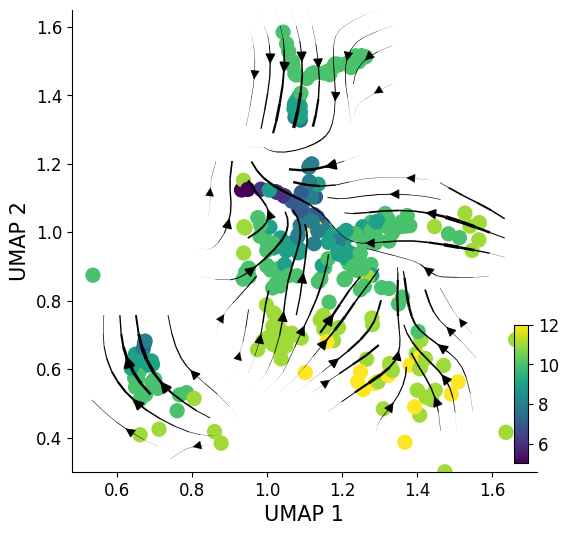

In [13]:
fig, ax = plt.subplots()
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=c, s=100)
# ax.scatter(globalumap.iloc[:, 0], globalumap.iloc[:, 1], s=1)
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1, grid_density=25, radius=0.12, lw_coef=12000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
# ax.set_title('C. elegans phylo velocity', fontsize=15)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)

cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0.3, 1.65])
plt.savefig('./figures/fig1/C.elegans_streamplot.pdf', dpi='figure', format='pdf')

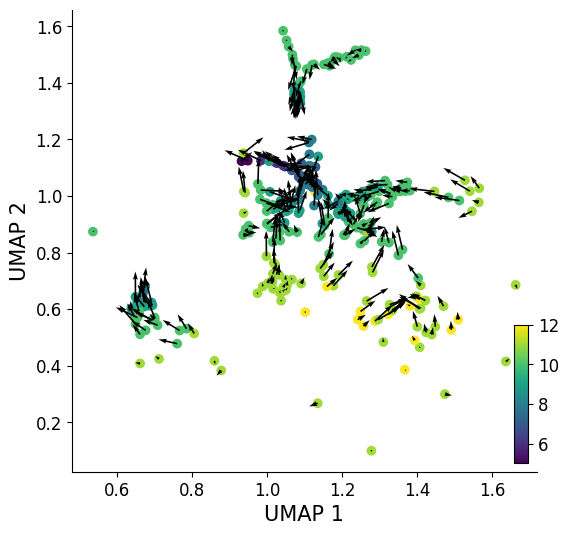

In [14]:
fig, ax = plt.subplots()
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=c)
# ax.scatter(globalumap.iloc[:, 0], globalumap.iloc[:, 1], s=1)
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'point')
ax.figure.set_size_inches(6, 6)
# ax.set_title('C. elegans phylo velocity', fontsize=15)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)

cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/C.elegans/C.elegans_quiver.pdf', dpi='figure', format='pdf')

In [15]:
anc = []
for cell in sd.cell_names:
    if cell[:-1] in sd.cell_names:
        anc.append(cell[:-1])
    elif cell[:-2] in sd.cell_names:
        anc.append(cell[:-2])
    else:
        anc.append(cell)

In [16]:
v_gt = []
for ta, tar in zip(anc, sd.cell_names):
    v_gt.append(sd.Xdr.loc[ta] - sd.Xdr.loc[tar])

In [17]:
v_gt = np.array(v_gt)

In [18]:
v_gt_norm = np.linalg.norm(v_gt, axis=1)
cf = np.quantile(v_gt_norm, 0.8)
v_gt[v_gt_norm>cf] = ((cf/v_gt_norm[v_gt_norm>cf])*v_gt[v_gt_norm>cf].T).T

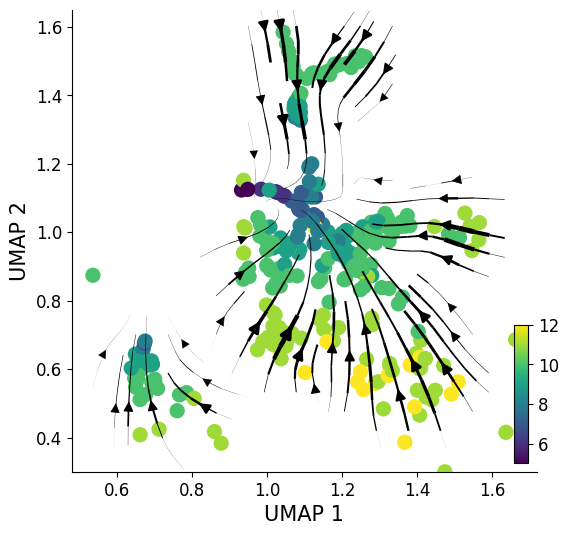

In [21]:
fig, ax = plt.subplots()
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=c, s=100)
# ax.scatter(globalumap.iloc[:, 0], globalumap.iloc[:, 1], s=1)
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), np.array(v_gt), ax, 'stream',streamdensity=1, grid_density=25, radius=0.12, lw_coef=300, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
# ax.set_title('C. elegans phylo velocity', fontsize=15)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)

cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0.3, 1.65])
plt.savefig('./figures/fig1/C.elegans_ground_truth.pdf', dpi='figure', format='pdf')

In [22]:
Xg, Yg, Ug, Vg = pv.ana_utils.velocity_embedding_to_grid(sd.Xdr.to_numpy(), v_gt, radius=0.12, grid_density=25)
grid_pts, grid_v_gt = [], []
for i in range(Xg.shape[0]):
    for j in range(Xg.shape[1]):
        grid_pts.append([Xg[i, j], Yg[i, j]])
        grid_v_gt.append([Ug[i, j], Vg[i, j]])
grid_pts = np.array(grid_pts)
grid_v_gt = np.array(grid_v_gt)

In [23]:
Xg, Yg, Ug, Vg = pv.ana_utils.velocity_embedding_to_grid(sd.Xdr.to_numpy(), sd.velocity_embeded, radius=0.12, grid_density=25)
grid_pts, grid_v = [], []
for i in range(Xg.shape[0]):
    for j in range(Xg.shape[1]):
        grid_pts.append([Xg[i, j], Yg[i, j]])
        grid_v.append([Ug[i, j], Vg[i, j]])
grid_pts = np.array(grid_pts)
grid_v = np.array(grid_v)

In [24]:
def format_pi(x, pos):
    return '$%.1f \pi$' % (x/np.pi)

In [25]:
cos_v, cos_vgt = [], []
for i, j in zip(grid_v, grid_v_gt):
    cos_v.append(i[0]/np.sqrt((i**2).sum()))
    cos_vgt.append(j[0]/np.sqrt((j**2).sum()))

In [26]:
cosv, cosvgt = [], []
for i, j in zip(cos_v, cos_vgt):
    if not (np.isnan(i) or np.isnan(j)):
        cosv.append(i)
        cosvgt.append(j)

In [27]:
from scipy.stats import pearsonr

In [49]:
plt.rcParams['font.size'] = 12

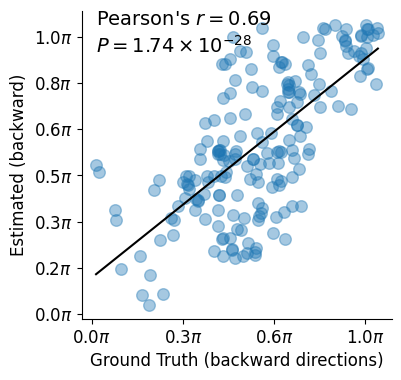

In [87]:
x = np.arccos(cosvgt)
y = np.arccos(cosv)


fig, ax = plt.subplots(figsize=(4, 4))
pv.corr_plot(x, y , ax, fontsize=14)
ax.set_xlabel('Ground Truth (backward directions)', fontsize=12)
ax.set_ylabel('Estimated (backward)', fontsize=12)
formatter = FuncFormatter(format_pi)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

# plt.savefig('./figures/C.elegans/phylovel_groundtr.pdf', dpi='figure', format='pdf')

In [65]:
rna_vel = np.load('/data3/wangkun/phylovelo_datasets/rnavelocity_umap.npy')
# fig, ax = plt.subplots(figsize=(7, 6))
# for pp, vv in zip(sd.Xdr.to_numpy(), 0.5*rna_vel):
#     ax.arrow(pp[0], pp[1], vv[0], vv[1], head_width=0.02)

In [54]:
Xg, Yg, Ug, Vg = pv.velocity_embedding_to_grid(sd.Xdr.to_numpy(), rna_vel, radius=0.12, grid_density=25)
grid_pts, grid_v_rna = [], []
for i in range(Xg.shape[0]):
    for j in range(Xg.shape[1]):
        grid_pts.append([Xg[i, j], Yg[i, j]])
        grid_v_rna.append([Ug[i, j], Vg[i, j]])
grid_pts = np.array(grid_pts)
grid_v_rna = np.array(grid_v_rna)

In [55]:
cos_v, cos_v_rna = [], []
for i, j in zip(grid_v_gt, grid_v_rna):
    cos_v.append(i[0]/np.sqrt((i**2).sum()))
    cos_v_rna.append(j[0]/np.sqrt((j**2).sum()))

In [56]:
cosvrna, cosvgt = [], []
for i, j in zip(cos_v_rna, cos_vgt):
    if not (np.isnan(i) or np.isnan(j)):
        cosvrna.append(i)
        cosvgt.append(j)

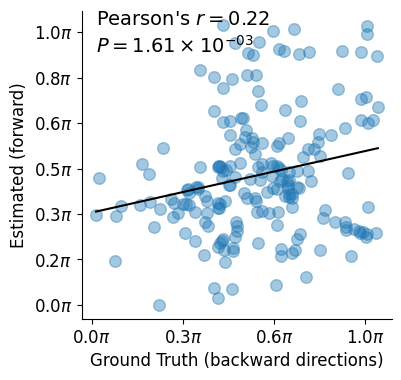

In [86]:
x = np.arccos(cosvgt)
y = np.arccos(cosvrna)



fig, ax = plt.subplots(figsize=(4, 4))
corr_plot(x, y , ax, fontsize=14)
ax.set_xlabel('Ground Truth (backward directions)', fontsize=12)
ax.set_ylabel('Estimated (forward)', fontsize=12)
formatter = FuncFormatter(format_pi)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
# plt.savefig('./figures/C.elegans/scv_groundtr.pdf', dpi='figure', format='pdf')

In [30]:
genes = list(sd.megs)
genes.sort(key=lambda x:dict(zip(sd.count.columns, sd.velocity))[x])

In [31]:
sel_genes = genes[:9]

In [32]:
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.stats import spearmanr

genes1 = sd.count.columns[sd.velocity>0]
genes2 = sd.count.columns[sd.velocity<0]

genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.count[i][np.argsort(cell_annotation.loc[sample.index]['embryo.time'][~count.index.duplicated(keep='first')].to_numpy())])))
genetraj1 = np.array(genetraj1)
genetraj1 = np.log(1+genetraj1)
# genetraj1 = (genetraj1.T / np.max(genetraj1, axis=1)).T

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.count[i][np.argsort(cell_annotation.loc[sample.index]['embryo.time'][~count.index.duplicated(keep='first')].to_numpy())])))
genetraj2 = np.array(genetraj2)
genetraj2 = np.log(1+genetraj2)

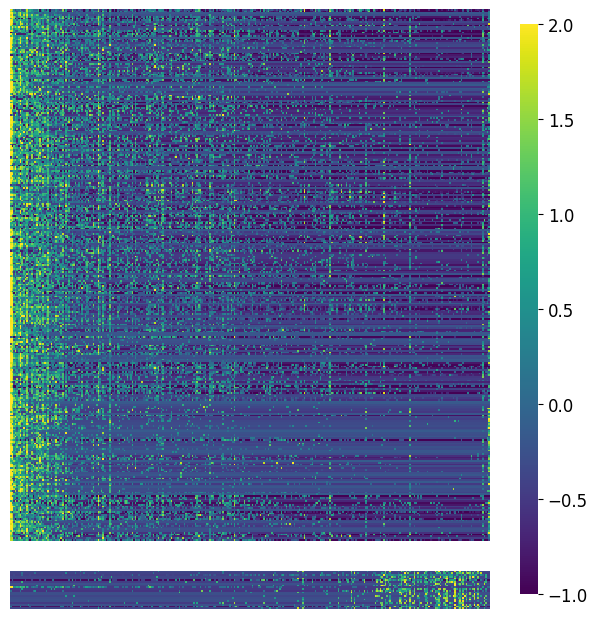

In [36]:
fig = plt.figure(figsize=(6, 6))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=2, vmin=-1, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2, cmap='viridis', ax=ax2, cbar=False,vmax=2, vmin=-1, xticklabels=False, yticklabels='')
plt.savefig('./figures/fig1/heatmap_full_embryotime.pdf', dpi='figure', format='pdf')

In [37]:
pv.calc_phylo_pseudotime(sd, n_neighbors=280)

  0%|          | 0/295 [00:00<?, ?it/s]

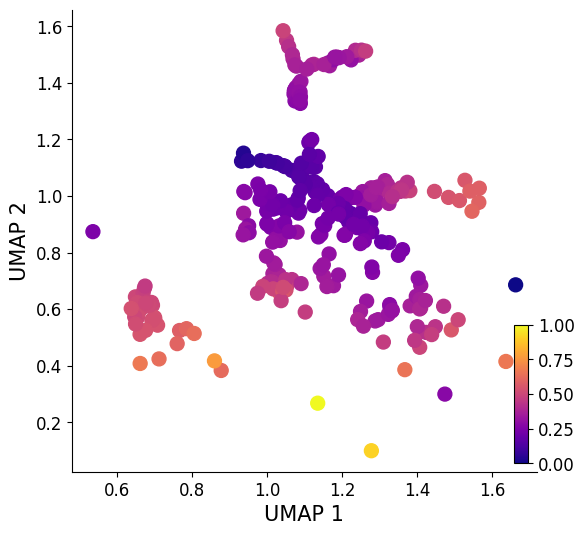

In [39]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(6, 6)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=sd.phylo_pseudotime,cmap='plasma')
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
plt.savefig('./figures/fig1/phylo_pseudotime.pdf', dpi='figure', format='pdf')

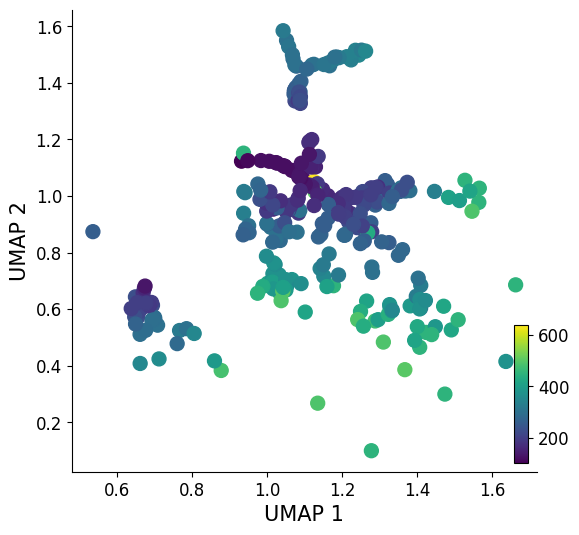

In [40]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(6, 6)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=cell_annotation.loc[sample.index]['embryo.time'][~count.index.duplicated(keep='first')].to_numpy(),cmap='viridis')
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')

plt.savefig('./figures/fig1/embryo_time.pdf', dpi='figure', format='pdf')

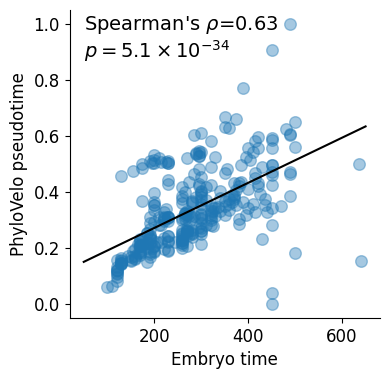

In [72]:

x = cell_annotation.loc[sample.index]['embryo.time'][~count.index.duplicated(keep='first')].to_numpy()
y = sd.phylo_pseudotime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(50,650,60) + b

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(50,650,60), y_est, '-', c='k')
ax.set_xlabel('Embryo time', fontsize=12)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=12)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(50, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=14)
ax.text(50, 0.88, r'$p={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [75]:
scv_res = pd.read_csv('/data3/wangkun/buckup/Celegans_scVelo_obs.csv')

In [77]:
import re

In [78]:
scv_res.index = [re.findall('(?<=:)[ATCG]+', i)[0] for i in scv_res.CellID]

In [79]:
latent_time = np.array([scv_res.loc[re.findall('[ATCG]+', i)[0]].latent_time for i in sample.index])[~count.index.duplicated(keep='first')]

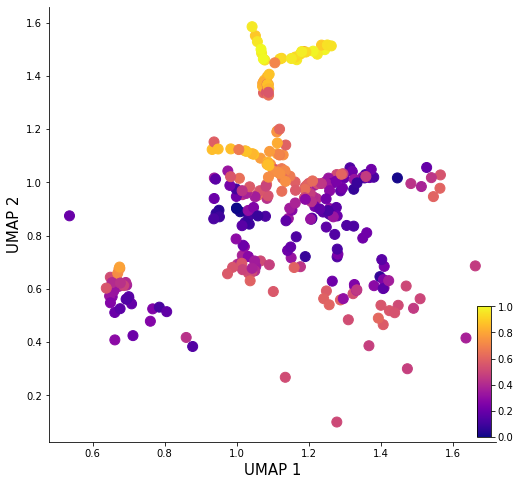

In [481]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(8,8)
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=latent_time,cmap='plasma')
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
plt.savefig('./figures/C.elegans/scv_latent_time.pdf', dpi='figure', format='pdf')

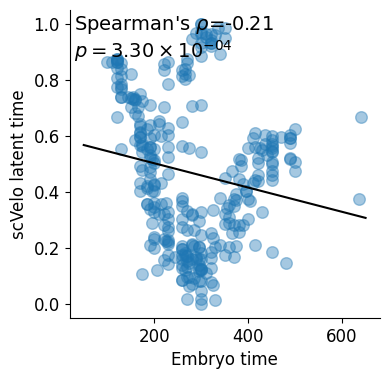

In [82]:

x = cell_annotation.loc[sample.index]['embryo.time'][~count.index.duplicated(keep='first')].to_numpy()
y = latent_time

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(50,650,60) + b

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(50,650,60), y_est, '-', c='k')
ax.set_xlabel('Embryo time', fontsize=12)
ax.set_ylabel('scVelo latent time', fontsize=12)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(30, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=14)
ax.text(30, 0.88, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/C.elegans/latenttime_embryotime.pdf', dpi='figure', format='pdf')

In [76]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.count.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('./megs/celegans.csv')

In [43]:
import pickle
with open('/data3/wangkun/result_sd/celegans.pkl', 'wb') as f:
    pickle.dump(sd, f)